In [1]:
import json
import re
import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:51, 1810.60it/s]


In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

#### Посчитайте количество отзывов в разных городах и на разные банки

In [5]:
data = pd.DataFrame(responses)
data.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.
3,643609,лицензия № 1481,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,2,NaN,False,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...
4,anfisa-2003,лицензия № 2766,ОТП Банк,г. Челябинск,2015-06-05 10:58:12,1,NaN,False,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку


In [6]:
data['city'].value_counts().head(15)

г. Москва             55354
г. Санкт-Петербург    14342
г. Екатеринбург        2337
г. Новосибирск         2300
г. Нижний Новгород     1976
г. Ростов-на-Дону      1891
г. Самара              1731
г. Челябинск           1507
г. Казань              1440
г. Краснодар           1262
г. Уфа                 1246
г. Красноярск          1236
г. москва              1217
г. Воронеж             1210
г. Пермь               1163
Name: city, dtype: int64

In [7]:
cities = data.loc[:, 'city'].copy()

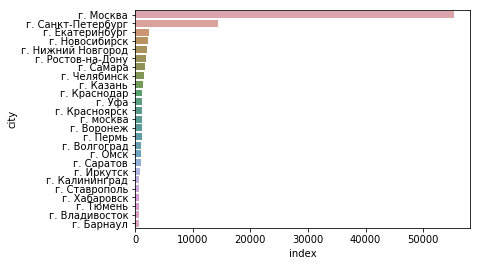

In [8]:
cities_extracted = cities.reset_index().groupby('city').count().sort_values('index', ascending=False)
sns.barplot(data=cities_extracted.reset_index().head(25), x='index', y='city', saturation=.5)

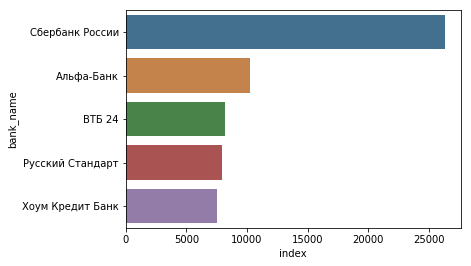

In [9]:
bank_names = data.loc[:,['bank_name']].copy()
banks = bank_names.reset_index().groupby('bank_name').count().sort_values('index', ascending=False).head(5)
sns.barplot(data=banks.reset_index(), x='index', y='bank_name', saturation=.5)

#### Постройте гистограмы длин слов в символах и в словах

In [10]:
df = pd.DataFrame()

lens = []
symbols = []
texts = []
for resp in responses:
    symbols.append(len(resp['text']))
    lens.append(len(resp['text'].split(' ')))
    texts.append(resp['text'])

grades = []
for resp in responses:
    grades.append(resp['rating_grade'])

df['lens'] = lens
df['symbols'] = symbols
df['texts'] = texts
df['grades'] = grades

In [11]:
#гистограма длин слов в словах

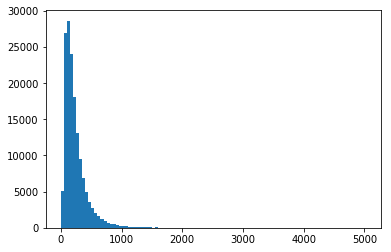

In [12]:
a = plt.hist(df.lens, bins = 100)

In [13]:
#гистограма длин слов в символах

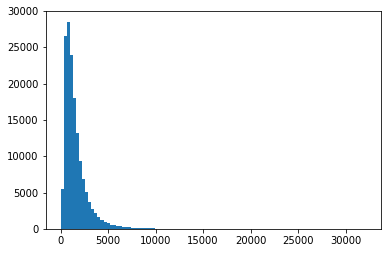

In [14]:
b = plt.hist(df.symbols, bins = 100)

#### Найдите 10 самых частых:слов

In [15]:
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""


df.texts = df.texts.str.lower()
df.texts = df.texts.apply(words_only)

In [16]:
from nltk import FreqDist
n_types = []
n_tokens = []
tokens = []
fd = FreqDist()
for index, row in df.iterrows():
    tokens = row['texts'].split()
    fd.update(tokens)
    n_types.append(len(fd))
    n_tokens.append(sum(fd.values()))
for i in fd.most_common(10):
    print(i)

('в', 1330550)
('и', 1058997)
('не', 855335)
('на', 707935)
('что', 640057)
('я', 577500)
('с', 464037)
('по', 372769)
('мне', 320958)
('банка', 275906)


#### Найдите 10 самых частых:слов без стоп-слов

In [17]:
from nltk.corpus import stopwords

mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

def lemmatize(text):
    m = MorphAnalyzer()
    try:
        lemmas1 = [m.parse(word)[0].normal_form for word in text.split()]
        return ' '.join(lemmas1) 
    except:
        return " "

mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь']
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

In [18]:
df['no_stopw'] = df['texts'].apply(remove_stopwords)

In [19]:
from nltk import FreqDist
n_types = []
n_tokens = []
tokens = []
fd = FreqDist()
for index, row in df.iterrows():
    tokens = row['no_stopw'].split()
    fd.update(tokens)
    n_types.append(len(fd))
    n_tokens.append(sum(fd.values()))
for i in fd.most_common(10):
    print(i)

('банка', 275906)
('банк', 215426)
('деньги', 131201)
('карту', 105829)
('карты', 101821)
('кредит', 81136)
('день', 76552)
('банке', 72169)
('заявление', 70423)
('очень', 66824)


#### Кривая Хипса

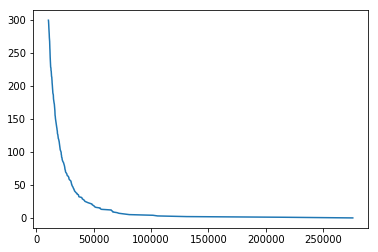

In [20]:
freqs = list(fd.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

#### Найдите 10 самых частых:существительных

In [21]:
from pymorphy2 import MorphAnalyzer

In [22]:
from wordcloud import WordCloud

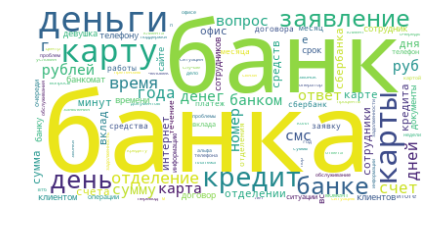

In [23]:
ma = MorphAnalyzer()
word_freq = []
for i in fd.most_common(200):
    p = ma.parse(i[0])[0].tag
    if {'NOUN'} in p:
        word_freq.append(i)
wd = WordCloud(background_color = 'white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure(figsize=(7,4))
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

#### Найдите 10 самых частых:лемм

In [24]:
from pymystem3 import Mystem

m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [25]:
from tqdm._tqdm_notebook import tqdm_notebook

tqdm_notebook.pandas('PROGRESS>>>')
df['lemma'] = df['no_stopw'].progress_apply(lemmatize)

In [26]:
df.head(3)

,lens,symbols,texts,grades,no_stopw,lemma
0,225,1523,добрый день я не являюсь клиентом банка и пору...,NaN,добрый день являюсь клиентом банка поручителем...,добрый день являться клиент банк поручитель кр...
1,141,1026,доброго дня являюсь держателем зарплатной карт...,NaN,доброго дня являюсь держателем зарплатной карт...,добрый день являться держатель зарплатной карт...
2,90,588,здравствуйте дублирую свое заявление от в до м...,NaN,здравствуйте дублирую свое заявление можайский...,здравствовать дублировать свой заявление можай...


In [29]:
df.to_csv('lemmatized.csv')

In [30]:
df = pd.read_csv('lemmatized.csv')

In [45]:
print('Слово "сотрудник" встрчается -"',fd['сотрудник'],'раз')
print('Слово "клиент" встрчается -"',fd['клиент'],'раз')
print(fd['сотрудник'] >fd['клиент'])

Слово "сотрудник" встрчается -" 31189 раз
Слово "клиент" встрчается -" 20160 раз
True


In [47]:
print('Слово "мошенничество" встречается -"',fd['мошенничество'],'раз')
print('Слово "доверие" встручается -"',fd['доверие'],'раз')

Слово "мошенничество" встречается -" 1106 раз
Слово "доверие" встручается -" 1156 раз


#### Часть 2. Тематическое моделирование [20/100]
Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?
Эта часть задания может быть сделана с использованием gensim.

In [37]:
import gensim

In [38]:
df.drop([153116,145330], inplace=True)

In [40]:
from gensim.corpora import *
texts = [df.lemma.iloc[i].split() for i in range(len(df))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [41]:
%%time
from gensim.models import  *
from gensim import similarities

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

Wall time: 2.95 s


In [42]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

Wall time: 1min 28s


In [48]:
lsi.show_topics(5)

[(0,
  '0.191*"карта" + 0.131*"кредит" + 0.113*"деньги" + 0.107*"заявление" + 0.105*"счет" + 0.100*"банкомат" + 0.099*"вклад" + 0.099*"отделение" + 0.094*"сбербанк" + 0.094*"сумма"'),
 (1,
  '-0.433*"вклад" + 0.338*"кредит" + -0.181*"банкомат" + 0.152*"страховка" + 0.147*"платеж" + 0.147*"задолженность" + -0.146*"карта" + -0.139*"открывать" + 0.135*"погашение" + -0.120*"очередь"'),
 (2,
  '-0.445*"вклад" + 0.300*"банкомат" + 0.235*"карта" + 0.191*"сбербанк" + -0.169*"кредит" + 0.132*"операция" + 0.132*"деньги" + 0.130*"заявление" + -0.127*"договор" + 0.122*"средство"'),
 (3,
  '-0.271*"вклад" + -0.218*"сумма" + 0.191*"номер" + -0.185*"руб" + 0.180*"заявка" + -0.163*"платеж" + -0.160*"погашение" + -0.154*"договор" + -0.147*"процент" + 0.145*"звонок"'),
 (4,
  '0.329*"вклад" + 0.265*"номер" + -0.250*"карта" + -0.211*"страховка" + -0.189*"заявка" + 0.189*"звонок" + -0.147*"кредит" + 0.138*"ваш" + 0.136*"телефон" + -0.121*"лимит"')]

Часть 3. Классификация текстов [40/100]
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).
Используйте accuracy и F-measure для оценки качества классификации.

Ниже написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.# 

#### Подготовка данных

In [49]:
df2 = df[(df['grades'] == 1) | (df['grades'] == 5)]
Y = df2['grades']
X = df2.drop('grades', axis = 1)
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in splitter.split(X, Y):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    
    Y_train = Y.iloc[train_index]
    Y_test = Y.iloc[test_index]
len(X_train), len(Y_train), len(X_test), len(Y_test)

(49679, 49679, 12420, 12420)

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import *
from sklearn.feature_extraction.text import *
from sklearn.metrics import *

C:\Users\ibelaya\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### tf-idf + svd

In [51]:
X_train['lemma']

49411     март год обращаться офис г владивосток океанск...
105566    я произош л й случай внесение наличный денежны...
153192    хотеть вступаться ситибанк являться зарплатной...
114422    день добрый мой жалоба сбербанк вернуть деньги...
139009    ого число открывать депозит заказывать карта п...
127557    руководитель небольшой достаточно молодой орга...
42407     добрый день хотеться спрашивать смотреть руков...
101099    сентябрь год пытаться оформлять кредитный карт...
106095    беда сотрудник компания который работать муж р...
68976     добрый день являться клиент банк оформлять кк ...
101340    прошедший пятница год пытаться полагать карта ...
29146     месяц доставать звонок альфа банк повод некий ...
14555     долгий сотрудничество другой банк решать отказ...
74733     офис прежний никто брать трубка процент вклад ...
80015     добрый день все хотеть рассказывать легкий рук...
99074     март год поменять фамилия тот пора несколько п...
2116      октябрь заказывать банк дебето

In [54]:
clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])

clf.fit(X_train['lemma'], Y_train)
true = Y_test
predictions = clf.predict(X_test['lemma'])

print("Precision: {0:6.2f}".format(precision_score(true, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(true, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(true, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(true, predictions)))
print(classification_report(true, predictions))

Precision:   0.57
Recall:   0.54
F1-measure:   0.54
Accuracy:   0.73
             precision    recall  f1-score   support

        1.0       0.78      0.91      0.84      9477
        5.0       0.36      0.17      0.23      2943

avg / total       0.68      0.73      0.69     12420



#### LDA

In [55]:
clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('lda', LatentDirichletAllocation()), 
    ('clf', RandomForestClassifier())
])

clf.fit(X_train['lemma'], Y_train)
predictions = clf.predict(X_test['lemma'])

print("Precision: {0:6.2f}".format(precision_score(true, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(true, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(true, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(true, predictions)))
print(classification_report(true, predictions))

C:\Users\ibelaya\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Precision:   0.86
Recall:   0.81
F1-measure:   0.83
Accuracy:   0.89
             precision    recall  f1-score   support

        1.0       0.90      0.95      0.93      9477
        5.0       0.82      0.66      0.73      2943

avg / total       0.88      0.89      0.88     12420



In [57]:
a = CountVectorizer(analyzer = 'char', ngram_range={2,3}).fit_transform(X_train['lemma'])

In [58]:
b = TfidfTransformer().fit_transform(a)
c = TruncatedSVD(n_components=5, random_state=0).fit_transform(b)

In [59]:
d = TSNE(n_components=2, perplexity=5, verbose=0).fit_transform(c)
e = RandomForestClassifier()